In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/content/drive/MyDrive/intern projects/CloudWatch_Traffic_Web_Attack.csv')
print("Shape:", df.shape)
df.head()


Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [3]:
# Convert to datetime format
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country codes
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

# Check for nulls
print(df.isnull().sum())


bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [8]:
# Calculate session duration
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Standardize numeric features
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['bytes_in', 'bytes_out', 'duration_seconds']])
scaled_df = pd.DataFrame(scaled, columns=['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration'], index=df.index)

# One-hot encode categorical
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['src_ip_country_code']])
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['src_ip_country_code']), index=df.index)

# Merge
df = pd.concat([df, scaled_df, encoded_df], axis=1)

In [9]:
# Select relevant features for anomaly detection
features = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration'] + list(encoded_df.columns)
X = df[features]

# Train Isolation Forest model
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
model.fit(X)

# Predict anomalies
df['anomaly_score'] = model.decision_function(X)
df['is_anomaly'] = model.predict(X)

# Display the number of anomalies detected
print("Number of anomalies detected:", df[df['is_anomaly'] == -1].shape[0])

Number of anomalies detected: 69


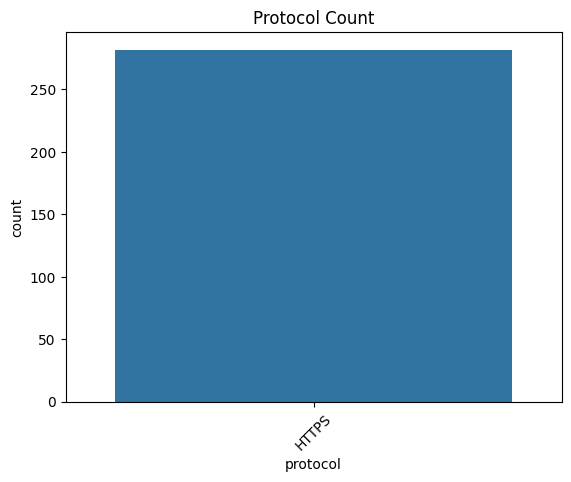

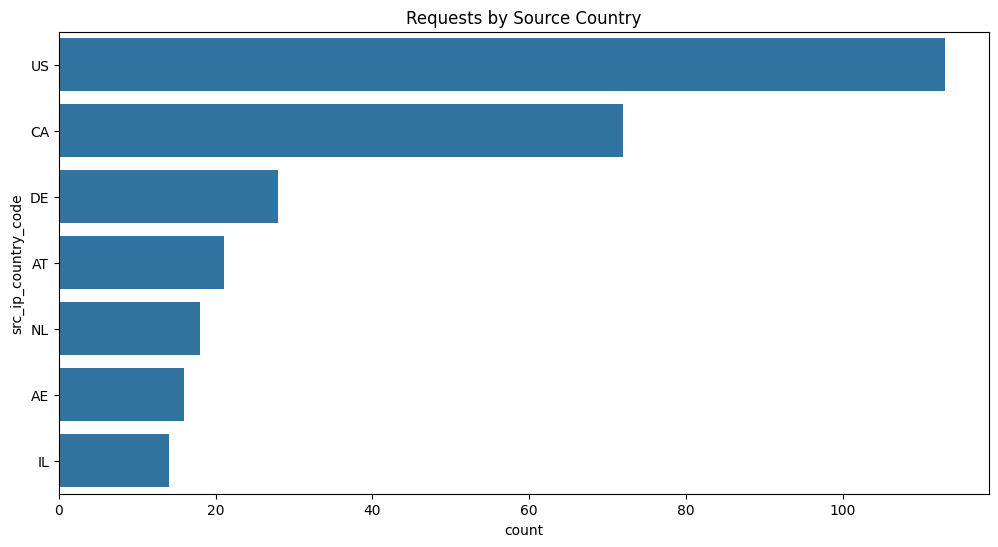

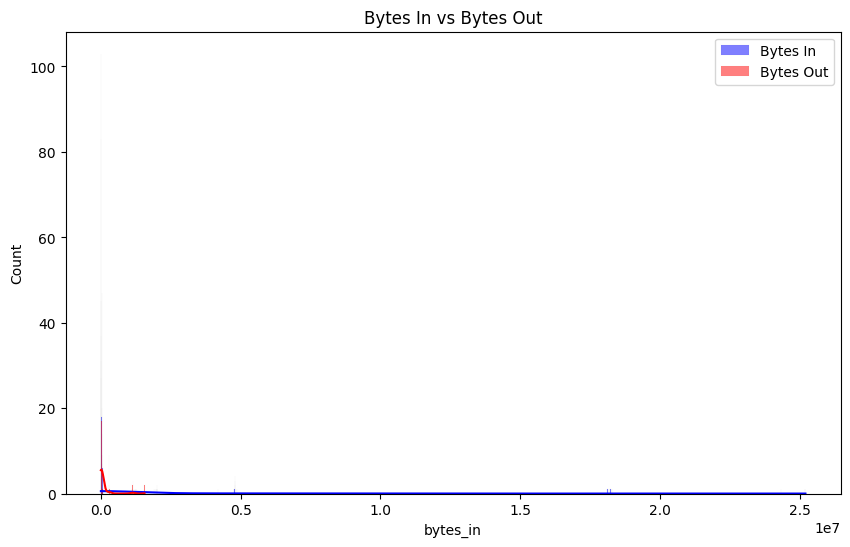

In [10]:
# Protocol Count
sns.countplot(x='protocol', data=df)
plt.title("Protocol Count")
plt.xticks(rotation=45)
plt.show()

# Source Country IPs
plt.figure(figsize=(12,6))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title("Requests by Source Country")
plt.show()

# Bytes Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['bytes_in'], kde=True, color='blue', label='Bytes In')
sns.histplot(df['bytes_out'], kde=True, color='red', label='Bytes Out')
plt.legend()
plt.title("Bytes In vs Bytes Out")
plt.show()


anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


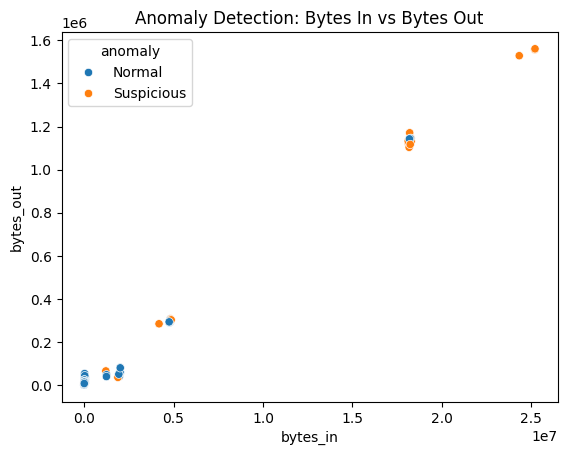

In [11]:
features = df[['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration']]
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

# Check anomaly count
print(df['anomaly'].value_counts())

# Plot anomalies
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df)
plt.title("Anomaly Detection: Bytes In vs Bytes Out")
plt.show()


In [12]:
# Encode target for classification
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

X = df[['bytes_in', 'bytes_out', 'duration_seconds']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



<Figure size 1200x600 with 0 Axes>

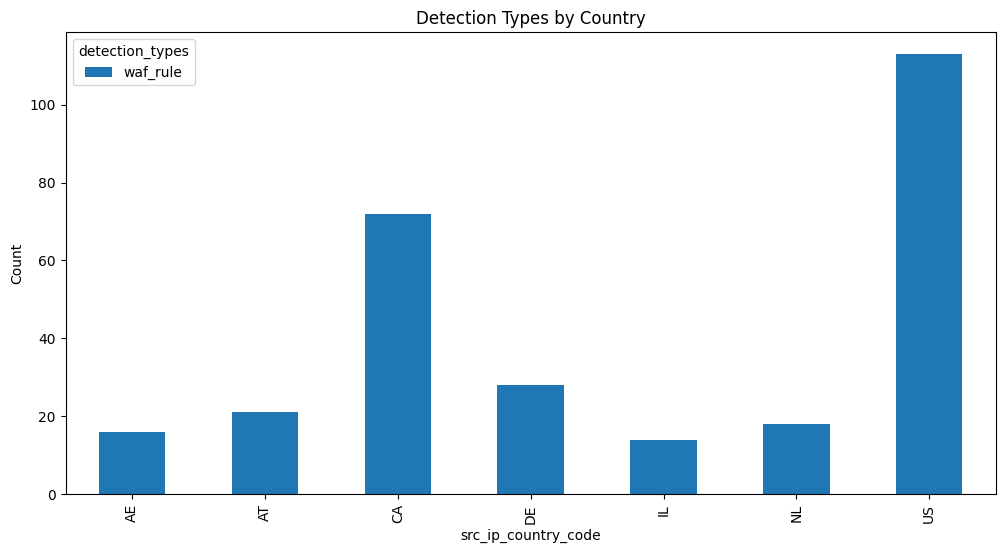

In [13]:
# Detection Type by Country
plt.figure(figsize=(12,6))
detection_by_country = pd.crosstab(df['src_ip_country_code'], df['detection_types'])
detection_by_country.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Detection Types by Country")
plt.ylabel("Count")
plt.show()


In [ ]:
                                   #Final Insights to Use
#HTTPS is the dominant protocol in the dataset.
#Most traffic originates from US, CA, and DE.
#The Bytes In vs Bytes Out histogram shows traffic distribution, with some extreme spikes.
#The Anomaly Detection plot highlights suspicious sessions with abnormal byte patterns.
#Detection Types by Country confirms that 'waf_rule' threats are mostly from US, CA, and DE.
#➡️ Overall, there's a clear concentration of suspicious activity from a few countries, and anomaly detection helps visually flag these unusual patterns.